# RNEEP for partial information problem

In [1]:
import sys

sys.path.append('..')

In [2]:
from argparse import Namespace

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy import stats
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from misc.sampler import CartesianSeqSampler
from toy.ratchet import simulation, ep_per_step, analytic_etpy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%config InlineBackend.figure_format = 'retina'

## Recurrent Neural Network NEEP (RNEEP)

In [3]:
class RNEEP(nn.Module):
    def __init__(self, opt):
        super(RNEEP, self).__init__()
        self.encoder = nn.Embedding(opt.n_token, opt.n_input)
        self.rnn = nn.GRU(opt.n_input, opt.n_hidden, opt.n_layer)
        self.fc = nn.Linear(opt.n_hidden, 1)

        self.nhid = opt.n_hidden
        self.nlayers = opt.n_layer

    def forward(self, x):
        # Note: shape of x is (seq_length, batch_size)
        bsz = x.size(1)
        h_f0 = self.init_hidden(bsz)
        emb_forward = self.encoder(x)
        output_f, _ = self.rnn(emb_forward, h_f0)

        h_r0 = self.init_hidden(bsz)
        x_r = torch.flip(x, [0])
        emb_reverse = self.encoder(x_r)
        output_r, _ = self.rnn(emb_reverse, h_r0)
        
        # Equation (9) in the paper
        out = self.fc(output_f.mean(dim=0)) - self.fc(output_r.mean(dim=0))
        return out

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return weight.new_zeros(self.nlayers, bsz, self.nhid).detach()

### Training Algorithm

In [4]:
def train(opt, model, optim, trajs, sampler):
    model.train()
    batch = next(sampler)
    x = trajs[batch].to(opt.device)

    ent_production = model(x)
    optim.zero_grad()
    
    # The objective function J. Equation (2)
    loss = (-ent_production + torch.exp(-ent_production)).mean()
    loss.backward()
    optim.step()
    return loss.item()


def validate(opt, model, trajs, sampler):
    model.eval()

    ret = []
    loss = 0
    with torch.no_grad():
        for batch in sampler:
            x = trajs[batch].to(opt.device)
            
            ent_production = model(x)
            entropy = ent_production.cpu().squeeze().numpy()
            ret.append(entropy)
            loss += (- ent_production + torch.exp(-ent_production)).sum().cpu().item()
    loss = loss / sampler.size
    ret = np.concatenate(ret)
    ret = ret.reshape(opt.M, -1)
    return ret, loss

### Hyper-parameters

In [5]:
opt = Namespace()
opt.device = 'cuda:0' 
opt.batch_size = 4096
opt.test_batch_size = 5000
opt.n_token = 3
opt.n_input = 128
opt.n_hidden = 128
opt.n_layer = 2

opt.lr = 0.0001
opt.wd = 5e-5

opt.record_freq = 1000
opt.seed = 398

torch.manual_seed(opt.seed)

# Trajectory sampling

In [6]:
opt.M = 1             # number of trajectories
opt.L = 10000000      # lenth of a trjectory
opt.n = 32            # sequence length (As increasing n training will be slow.)
opt.V = 1.5           # potential 

data = simulation(2*opt.M, opt.L, opt.V, seed=0) 
trajs = data[:opt.M]       # train
test_trajs = data[opt.M:]  # test

In [7]:
# Remove states 3, 4, and 5
trajs_t = torch.from_numpy(trajs).long().to(opt.device) % 3
test_trajs_t = torch.from_numpy(test_trajs).long().to(opt.device) % 3

## Build model & Training

In [8]:
model = RNEEP(opt)
model = model.to(opt.device)
optim = torch.optim.Adam(model.parameters(), opt.lr, weight_decay=opt.wd)

train_sampler = CartesianSeqSampler(opt.M, opt.L, opt.n, opt.batch_size, device=opt.device)
test_sampler = CartesianSeqSampler(opt.M, opt.L, opt.n, opt.test_batch_size, device=opt.device, train=False)

In [9]:
opt.n_iter = 50000 # number of training iteration

losses = []
moving_loss = train(opt, model, optim, trajs_t, train_sampler)
for i in tqdm(range(1, opt.n_iter)):
    loss = train(opt, model, optim, trajs_t, train_sampler)
    moving_loss = 0.999 * moving_loss + 0.001 * loss
    losses.append(moving_loss)

### Training dynamics of $J(\theta)$ 

Text(0.5, 0, 'iteration')

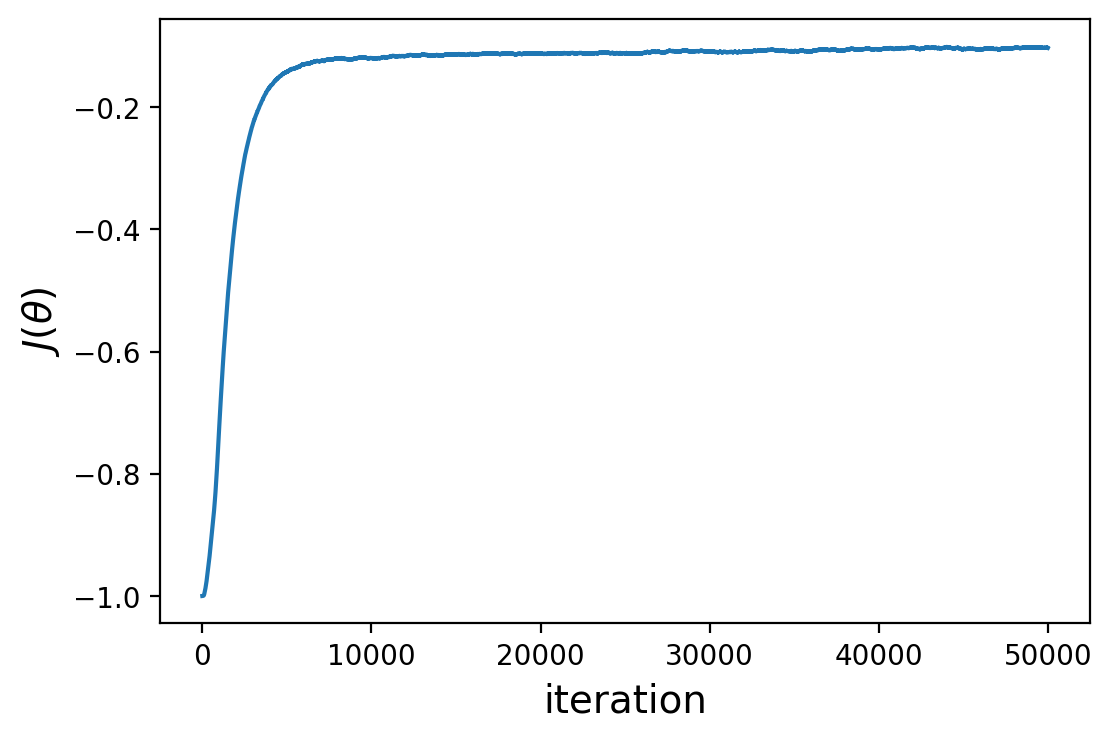

In [10]:
plt.figure(dpi=100)
plt.plot(-np.array(losses))

plt.ylabel('$J(\\theta)$', fontsize=14)
plt.xlabel('iteration', fontsize=14)

### Testing

In [11]:
pred, _ = validate(opt, model, test_trajs_t, test_sampler)
pred = pred.flatten()
ent = analytic_etpy(test_trajs[0].flatten(), opt.V)

cum_pred = np.cumsum(pred)
cum_ent = np.cumsum(ent)

## Results

### Single trajectory EP & EP per step

Analytic EP per step : 0.1306
Estimated EP per step : 0.0278


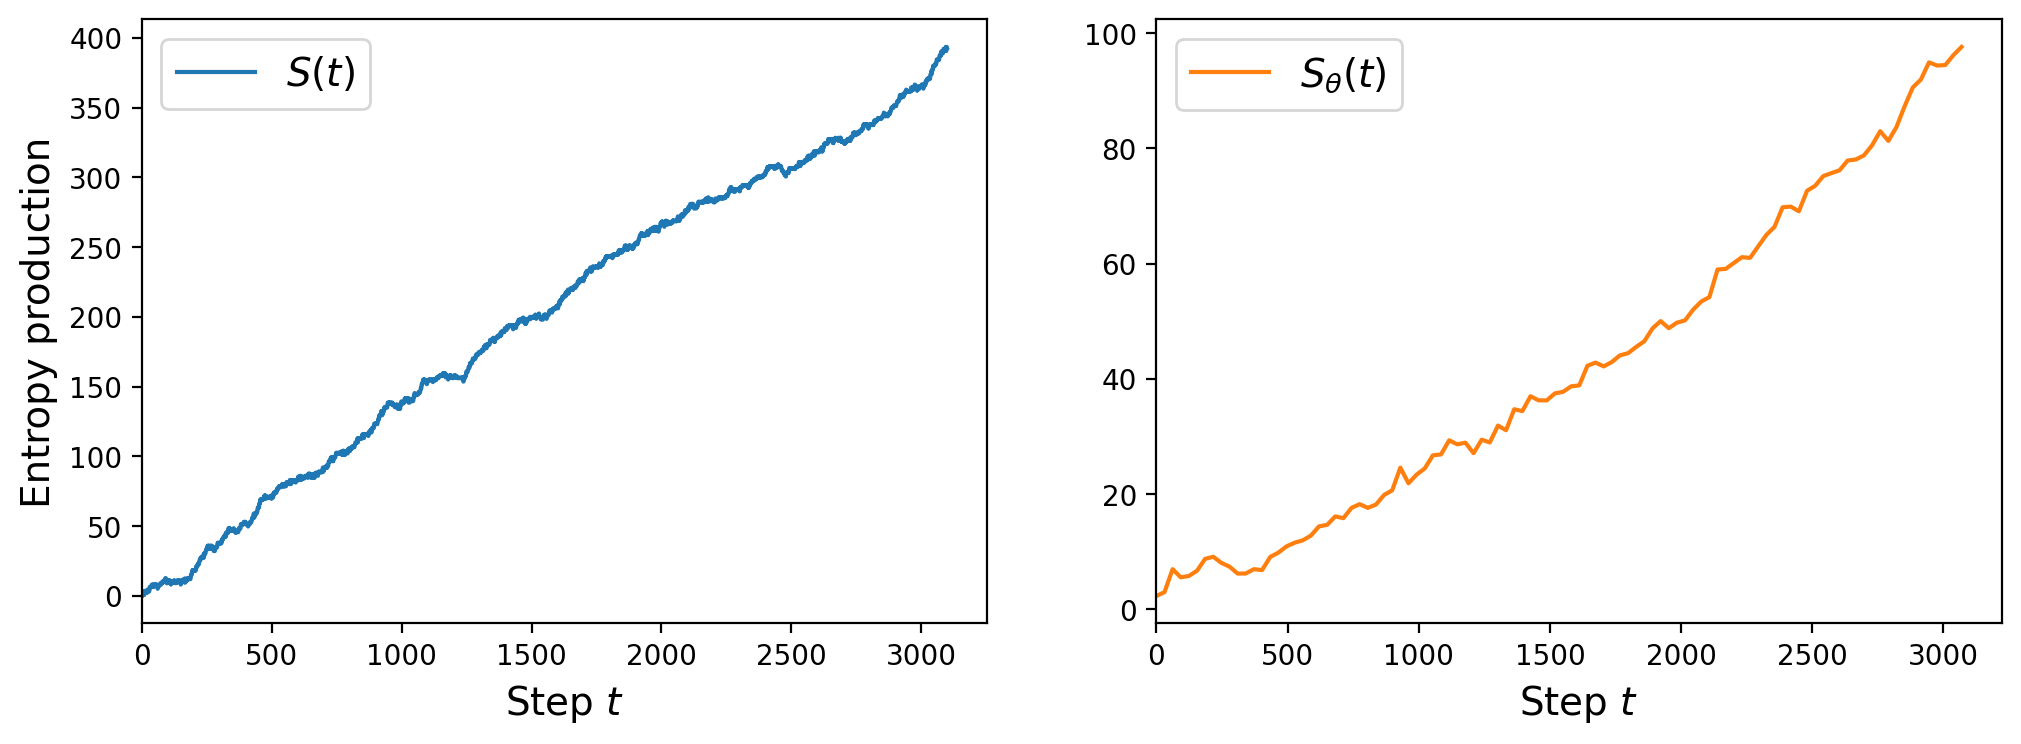

In [13]:
start = 0
end = 100

plt.figure(figsize=(12, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(cum_ent[start*(opt.n-1):end*(opt.n-1)], label=r"$S(t)$")
plt.xlim(0)

plt.xlabel("Step $t$", fontsize=14)
plt.ylabel("Entropy production", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
ys = cum_pred[start:end]
xs = np.arange(len(ys)) * (opt.n-1)
plt.plot(xs, ys, label='$S_\\theta(t)$', color='C1')
plt.xlim(0)

plt.xlabel("Step $t$", fontsize=14)
plt.legend(fontsize=14)

slope, _, _, _, _ = stats.linregress(np.arange(len(cum_pred)) * (opt.n-1), cum_pred)
print("Analytic EP per step : %.4f" %ep_per_step(opt.V))
print("Estimated EP per step : %.4f" %slope)